In [1]:
# Add root folder to python path
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

# Add some common packages
import numpy as np
import pandas as pd
import math
import scipy.stats as ss
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Set up the failure mode class
from pof.failure_mode import FailureMode
from pof.condition import Condition

fm = FailureMode(alpha=50, beta=1.5, gamma=10)

 ['cm']
updating condition - wall_thickness
updating condition - external_diameter
condition wall_thickness, start 107, initiate 130, end 200
condition external_diameter, start 107, initiate 130, end 200
107 ['cm']
updating condition - wall_thickness
updating condition - external_diameter
condition wall_thickness, start 108, initiate 122, end 200
condition external_diameter, start 108, initiate 122, end 200
108 ['cm']
updating condition - wall_thickness
updating condition - external_diameter
condition wall_thickness, start 109, initiate 169, end 200
condition external_diameter, start 109, initiate 169, end 200
109 ['cm']
updating condition - wall_thickness
updating condition - external_diameter
condition wall_thickness, start 110, initiate 145, end 200
condition external_diameter, start 110, initiate 145, end 200
110 ['inspection' 'cm']
110 ['inspection' 'cm']
updating condition - wall_thickness
updating condition - external_diameter
condition wall_thickness, start 111, initiate 183, e

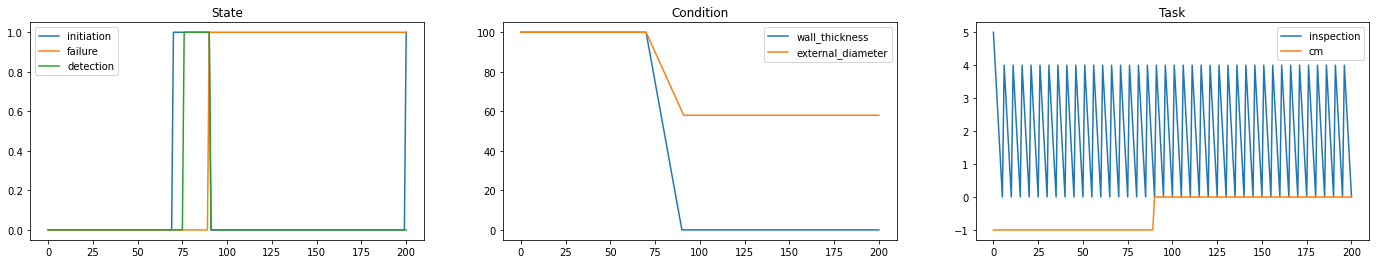

In [3]:
timeline = fm.sim_timeline(200, verbose=True)
fm.plot_timeline()

In [5]:
fm.conditions['wall_thickness'].__dict__

{'name': 'default',
 'pf_curve': 'linear',
 'pf_curve_params': [-5],
 'decreasing': True,
 'pf_interval': NotImplemented,
 'pf_std': NotImplemented,
 't_condition': 0,
 't_max': 20,
 't_accumulated': 0,
 'condition_perfect': 100,
 'condition_accumulated': 0,
 'condition': 100,
 'condition_failed': 0,
 'threshold_detection': 100,
 'threshold_failure': 0,
 'condition_profile': array([100.,  95.,  90.,  85.,  80.,  75.,  70.,  65.,  60.,  55.,  50.,
         45.,  40.,  35.,  30.,  25.,  20.,  15.,  10.,   5.,   0.]),
 'detected': NotImplemented,
 'initiated': NotImplemented}

In [6]:
fm.init_timeline(00)
fm.plot_timeline()

IndexError: index 0 is out of bounds for axis 0 with size 0

In [7]:
fm.tasks['ocr'].sim_completion(t_now=90, timeline=fm.timeline, states=fm.get_states(), conditions=fm.conditions)

AttributeError: 'tuple' object has no attribute 'items'

In [8]:
fm.tasks['ocr'].sim_timeline(t_end=100, timeline = fm.timeline)

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [9]:
fm.conditions['wall_thickness'].__dict__
fm.tasks['ocr'].__dict__

{'activity': 'on_condition_repair',
 'trigger': 'condition',
 'trigger_comp': '1.1.2',
 '_package': NotImplemented,
 '_impacts_parent': NotImplemented,
 '_impacts_children': False,
 'cost': 100,
 'labour': 'trade',
 'spares': 'pole',
 'equipment': 'ewp',
 'consequence': <pof.consequence.Consequence at 0x27517796df0>,
 'state_impacts': {'initiation': False, 'detection': False, 'failure': False},
 'condition_impacts': ({'wall_thickness': {'target': None,
    'reduction_factor': 0,
    'method': 'reduction_fa',
    'axis': 'condition'}},),
 'p_effective': 1,
 'triggers': {'time': {}, 'state': {}, 'condition': {}},
 'time_triggers': {},
 'state_triggers': {'detection': True},
 'condition_triggers': {'wall_thickness': {'lower': 50, 'upper': 70}},
 'time_imapcts': {},
 'state': 'up',
 't_completion': [90],
 '_timeline': NotImplemented,
 '_count_checked': NotImplemented,
 '_count_triggered': NotImplemented,
 '_count_completed': 0,
 'task_type': 'immediate'}

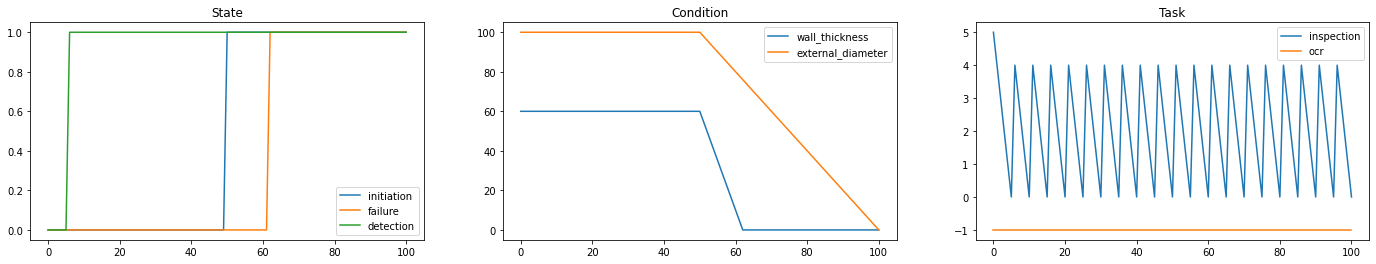

In [10]:
fm.conditions['wall_thickness'].set_condition(60)
fm.conditions['wall_thickness'].set_condition_profile()
fm.sim_timeline(100)
fm.plot_timeline()

In [11]:
fm.conditions['wall_thickness'].__dict__
#fm.tasks['ocr'].__dict__

{'name': 'default',
 'pf_curve': 'linear',
 'pf_curve_params': [-5],
 'decreasing': True,
 'pf_interval': NotImplemented,
 'pf_std': NotImplemented,
 't_condition': 8,
 't_max': 20,
 't_accumulated': 0,
 'condition_perfect': 100,
 'condition_accumulated': 0,
 'condition': 60,
 'condition_failed': 0,
 'threshold_detection': 100,
 'threshold_failure': 0,
 'condition_profile': array([100.,  95.,  90.,  85.,  80.,  75.,  70.,  65.,  60.,  55.,  50.,
         45.,  40.,  35.,  30.,  25.,  20.,  15.,  10.,   5.,   0.]),
 'detected': NotImplemented,
 'initiated': NotImplemented}

In [10]:
t_c = dict()

for task_name, task in fm.tasks.items():

    time, quantity= np.unique(task.t_completion, return_counts=True)
    cost = quantity * task.cost

    t_c[task_name] = dict(
        time = time,
        cost = cost,
        )

In [11]:
for task
plt.bar(time, cost, color = 'skyblue')
plt.fill_between(time, cost.cumsum(), alpha =0.4, color = 'skyblue')

SyntaxError: invalid syntax (<ipython-input-11-512f98706da4>, line 1)

In [12]:
a[0:10]

NameError: name 'a' is not defined